# Tests with Kronos for Forcasting


In [8]:
%pip install transformers torch einops

Note: you may need to restart the kernel to use updated packages.


In [47]:
import sys
import os
import torch
import pandas as pd 
import matplotlib.pyplot as plt

# Ensure the kronos directory is in the Python path.
sys.path.append(os.getcwd() + "/kronos/")

from model import Kronos, KronosTokenizer, KronosPredictor

In [13]:
# Load from Hugging Face Hub
tokenizer = KronosTokenizer.from_pretrained("NeoQuasar/Kronos-Tokenizer-base")
model = Kronos.from_pretrained("NeoQuasar/Kronos-small")

In [50]:
# Instantiate Predictor

if torch.backends.mps.is_available():
    device = "mps"
    print("Using MPS")
elif torch.cuda.is_available():
    device = "cuda:0"
    print("Using CUDA")
else:
    device = "cpu"
    print("Using CPU")

predictor = KronosPredictor(model, tokenizer, device=device, max_context=512)

Using MPS


In [49]:
df = pd.read_csv("~/Downloads/btcusd_1-min_data.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df = df.rename(columns={
    'Timestamp': 'timestamp',
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
})
df

,timestamp,open,high,low,close,volume
0,2012-01-01 10:01:00,4.58,4.58,4.58,4.58,0.000000
1,2012-01-01 10:02:00,4.58,4.58,4.58,4.58,0.000000
2,2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0.000000
3,2012-01-01 10:04:00,4.58,4.58,4.58,4.58,0.000000
4,2012-01-01 10:05:00,4.58,4.58,4.58,4.58,0.000000
...,...,...,...,...,...,...
7235673,2025-10-04 23:54:00,122410.00,122410.00,122410.00,122410.00,0.010217
7235674,2025-10-04 23:55:00,122410.00,122430.00,122410.00,122430.00,0.149768
7235675,2025-10-04 23:56:00,122442.00,122442.00,122442.00,122442.00,0.101102
7235676,2025-10-04 23:57:00,122442.00,122442.00,122441.00,122442.00,0.029213


In [51]:
def plot_prediction(kline_df, pred_df):
    pred_df.index = kline_df.index[-pred_df.shape[0]:]
    sr_close = kline_df['close']
    sr_pred_close = pred_df['close']
    sr_close.name = 'Ground Truth'
    sr_pred_close.name = "Prediction"

    sr_volume = kline_df['volume']
    sr_pred_volume = pred_df['volume']
    sr_volume.name = 'Ground Truth'
    sr_pred_volume.name = "Prediction"

    close_df = pd.concat([sr_close, sr_pred_close], axis=1)
    volume_df = pd.concat([sr_volume, sr_pred_volume], axis=1)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    ax1.plot(close_df['Ground Truth'], label='Ground Truth', color='blue', linewidth=1.5)
    ax1.plot(close_df['Prediction'], label='Prediction', color='red', linewidth=1.5)
    ax1.set_ylabel('Close Price', fontsize=14)
    ax1.legend(loc='lower left', fontsize=12)
    ax1.grid(True)

    ax2.plot(volume_df['Ground Truth'], label='Ground Truth', color='blue', linewidth=1.5)
    ax2.plot(volume_df['Prediction'], label='Prediction', color='red', linewidth=1.5)
    ax2.set_ylabel('Volume', fontsize=14)
    ax2.legend(loc='upper left', fontsize=12)
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [42]:
lookback = 100
pred_len = 10

# x_df = df.loc[:lookback-1, ['open', 'high', 'low', 'close', 'volume']]
# x_timestamp = df.loc[:lookback-1, 'timestamp']
# y_timestamp = df.loc[lookback:lookback+pred_len-1, 'timestamp']

# Select the last 100 rows for input features
x_df = df.iloc[-(lookback + pred_len):-pred_len][['open', 'high', 'low', 'close', 'volume']]
x_timestamp = pd.Series(df.iloc[-(lookback + pred_len):-pred_len]['timestamp'])

# Select the last 10 rows for prediction timestamps
y_timestamp = pd.Series(df.iloc[-pred_len:]['timestamp'])

In [45]:
y_timestamp

7235668   2025-10-04 23:49:00
7235669   2025-10-04 23:50:00
7235670   2025-10-04 23:51:00
7235671   2025-10-04 23:52:00
7235672   2025-10-04 23:53:00
7235673   2025-10-04 23:54:00
7235674   2025-10-04 23:55:00
7235675   2025-10-04 23:56:00
7235676   2025-10-04 23:57:00
7235677   2025-10-04 23:58:00
Name: timestamp, dtype: datetime64[ns]

In [52]:
# 3. Prepare Data
df = pd.read_csv("kronos/examples/data/XSHG_5min_600977.csv")
df['timestamps'] = pd.to_datetime(df['timestamps'])

lookback = 400
pred_len = 120

x_df = df.loc[:lookback-1, ['open', 'high', 'low', 'close', 'volume', 'amount']]
x_timestamp = df.loc[:lookback-1, 'timestamps']
y_timestamp = df.loc[lookback:lookback+pred_len-1, 'timestamps']

In [54]:
y_timestamp

400   2024-06-28 14:05:00
401   2024-06-28 14:10:00
402   2024-06-28 14:15:00
403   2024-06-28 14:20:00
404   2024-06-28 14:25:00
              ...        
515   2024-07-03 10:10:00
516   2024-07-03 10:15:00
517   2024-07-03 10:20:00
518   2024-07-03 10:25:00
519   2024-07-03 10:30:00
Name: timestamps, Length: 120, dtype: datetime64[ns]

In [55]:
# 4. Make Prediction
pred_df = predictor.predict(
    df=x_df,
    x_timestamp=x_timestamp,
    y_timestamp=y_timestamp,
    pred_len=pred_len,
    T=1.0,
    top_p=0.9,
    sample_count=1,
    verbose=True
)

# 5. Visualize Results
print("Forecasted Data Head:")
print(pred_df.head())


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:19<00:00,  6.23it/s]


Forecasted Data Head:
                          open       high        low      close       volume  \
timestamps                                                                     
2024-06-28 14:05:00  10.807288  10.836599  10.789008  10.802865   904.160156   
2024-06-28 14:10:00  10.830423  10.830163  10.791967  10.794168   872.735474   
2024-06-28 14:15:00  10.800508  10.817746  10.792054  10.804611   714.907410   
2024-06-28 14:20:00  10.805070  10.825165  10.774553  10.814574  1301.247070   
2024-06-28 14:25:00  10.809438  10.819221  10.793911  10.802172   441.220276   

                           amount  
timestamps                         
2024-06-28 14:05:00  9.574419e+05  
2024-06-28 14:10:00  9.615544e+05  
2024-06-28 14:15:00  7.712865e+05  
2024-06-28 14:20:00  1.380701e+06  
2024-06-28 14:25:00  4.767206e+05  


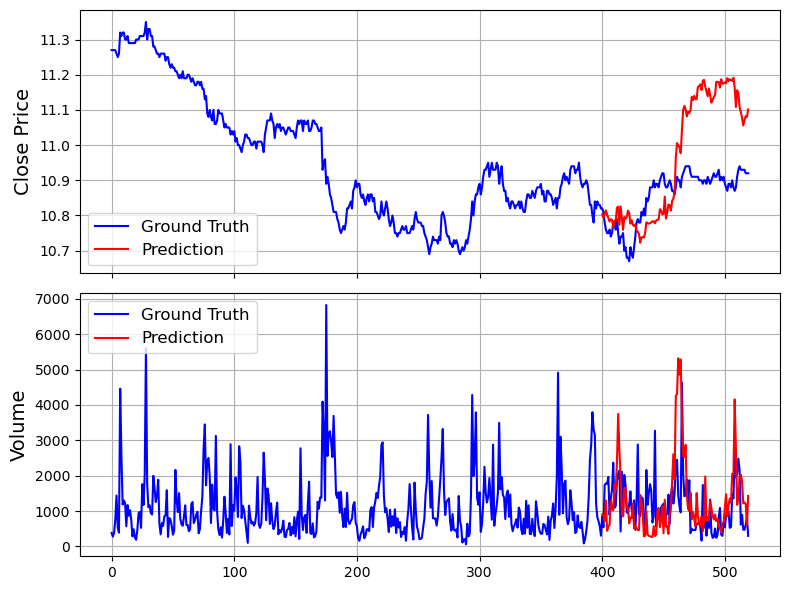

In [56]:
# Combine historical and forecasted data for plotting
kline_df = df.loc[:lookback+pred_len-1]

# visualize
plot_prediction(kline_df, pred_df)